## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

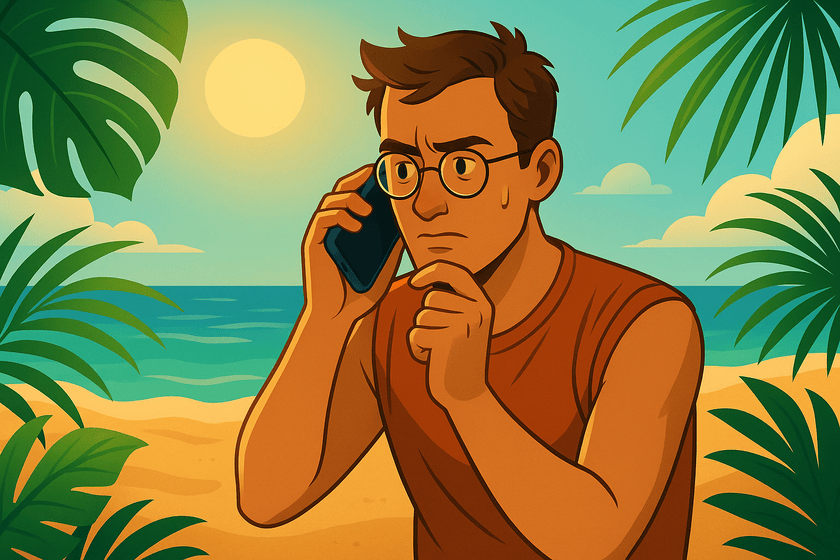

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

## Importy i dane

In [4]:
import torch
from torchvision import datasets
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cuda


Podstawowe info o naszym zbiorze danych

In [2]:
print(f"Liczba przykładów w zestawie treningowym: {len(train_dataset)}")
print(f"Liczba przykładów w zestawie testowym: {len(test_dataset)}")

Liczba przykładów w zestawie treningowym: 60000
Liczba przykładów w zestawie testowym: 10000


Zamieniamy na dataloadery, zeby ulatwic cały proces i nie musieć robić tego ręcznie

In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Wyświetlmy kilka zdjątek

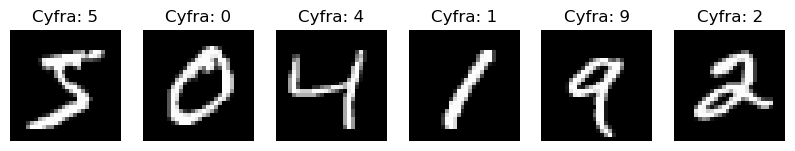

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i, (img, label) in enumerate([train_dataset[j] for j in range(6)]):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Cyfra: {label}')
    axes[i].axis('off')
plt.show()

To może teraz jeszcze zobaczymy jak wygląda jedno zdjęcie pod powłoką

In [5]:
print(f'{test_dataset[0][0].shape}')

torch.Size([1, 28, 28])


Widzimy zatem, że każde ze zdjęć ma jeden color channel, a jest wymariu 28x28, to ważne dla dalszych poczynań w modelu baseline - fc

## Train - Test functions

In [11]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoka {epoch+1}/{epochs}, Strata: {epoch_loss:.4f}")
    return losses

def test_model(model, test_loader):
    model.eval()
    accuracy = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Dokładność na zestawie testowym: {accuracy:.2f}%")
    return accuracy

## Baseline fullyconnected 

Fully connected to zwykła sieć neuronowa bez żadnych upiększeń, to co zostało nam ukazane jako pierwsze na wykładzie.

Dlaczego 28x28 jest ważne? Każdy z inputów będzie odpowiadał jednemu pixelowi ze zdjęcia, tzn że potrzebujemy 28*28 inputów, aby każdy piksel mógł "przejść"

Warto, też od razu zauważyć, że skoro chcemy się bawić w klasyfikacje to potrzebujemy mieć na wyjściu wymaganą liczbę klas, w tym wypadku będzie to 10

Funkcja flatten dodatkowo zamienia nasz obraz 2 wymiarowy na "zflattenowany" wektor 28*28 = 784, więc żaden piksel się nie gubi, ani nic. Chociaż do rezultatów tego rozwiązania przejdziemy zaraz.

In [7]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

Zatem zobaczymy rezultat takiego rozwiązania

In [8]:
print("\nTrenowanie modelu FC:")
fc_model = FCNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)
fc_losses = train_model(fc_model, train_loader, criterion, optimizer, epochs=10)
fc_accuracy = test_model(fc_model, test_loader)


Trenowanie modelu FC:
Epoka 1/10, Strata: 0.2425
Epoka 2/10, Strata: 0.0905
Epoka 3/10, Strata: 0.0594
Epoka 4/10, Strata: 0.0425
Epoka 5/10, Strata: 0.0325
Epoka 6/10, Strata: 0.0253
Epoka 7/10, Strata: 0.0222
Epoka 8/10, Strata: 0.0192
Epoka 9/10, Strata: 0.0162
Epoka 10/10, Strata: 0.0142
Dokładność na zestawie testowym: 97.91%


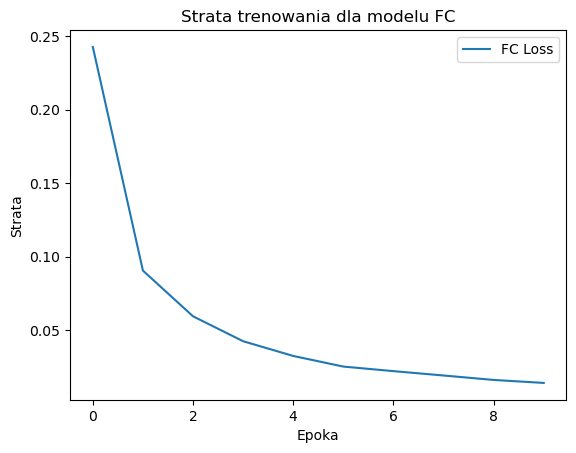

In [9]:
plt.plot(fc_losses, label='FC Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Strata trenowania dla modelu FC')
plt.legend()
plt.show()

Rezultat około 97-98 procent jest jak najbardziej normalny, ale zobaczymy jak poradzi sobie CNN

## CNN

Jaka jest nabardziej podstawowa różnica pomiędzy zwykłą siecią neuronową FC, a architekturą CNN? Zachowanie informacji przestrzennej naszego obrazu. Zamiast flattenować nasz obrazek "redukujemy" go, robimy tak zwany mapping featurów, który jest używany w wielu architekturach chociażby Autoencoderów.

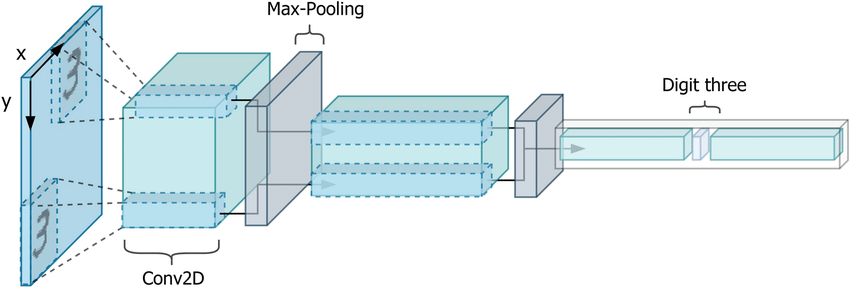
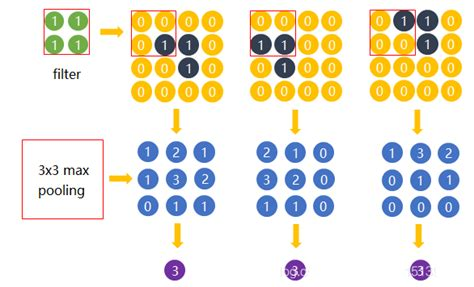

Operacja poolingu zmniejsza wymiarowość naszego obrazu, jednocześnie zachowując najważniejsze informacje o danym obrazie, zamiast po prostu wrzucić wszystko na "chama" do jednego wektora jak to było w przypadku FC

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

In [11]:
print("\nTrenowanie modelu CNN:")
CNN_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)
CNN_losses = train_model(CNN_model, train_loader, criterion, optimizer, epochs=10)
CNN_accuracy = test_model(CNN_model, test_loader)


Trenowanie modelu CNN:
Epoka 1/10, Strata: 0.2051
Epoka 2/10, Strata: 0.0580
Epoka 3/10, Strata: 0.0391
Epoka 4/10, Strata: 0.0288
Epoka 5/10, Strata: 0.0227
Epoka 6/10, Strata: 0.0174
Epoka 7/10, Strata: 0.0150
Epoka 8/10, Strata: 0.0119
Epoka 9/10, Strata: 0.0101
Epoka 10/10, Strata: 0.0099
Dokładność na zestawie testowym: 99.28%


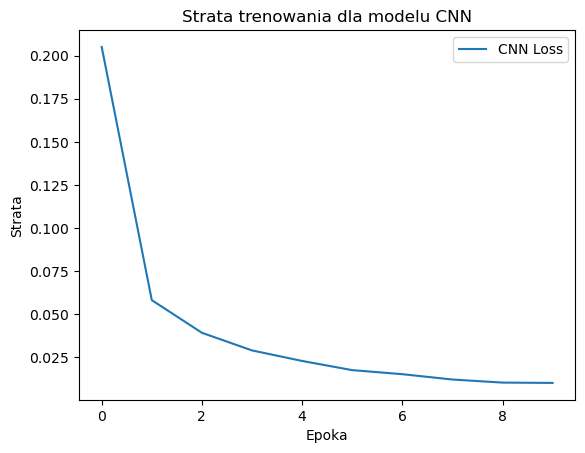

In [12]:
plt.plot(CNN_losses, label='CNN Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Strata trenowania dla modelu CNN')
plt.legend()
plt.show()

Rezultat nieco wyższy niż w FC jeżeli chodzi o accuracy jak i szybciej trenujący się model

## Porównanie obu modeli

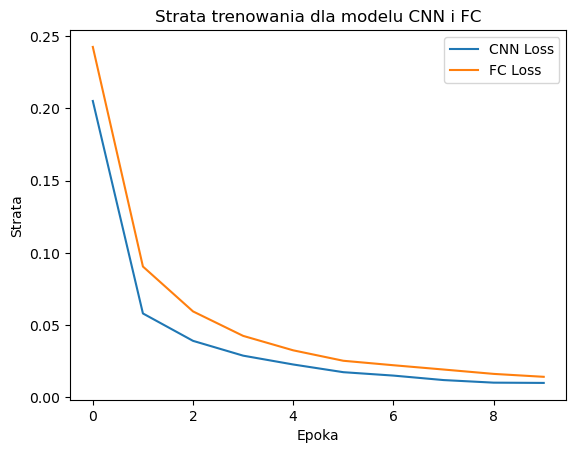

In [13]:
plt.plot(CNN_losses, label='CNN Loss')
plt.plot(fc_losses, label='FC Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Strata trenowania dla modelu CNN i FC')
plt.legend()
plt.show()

Widać, że model CNN uczy się szybciej oraz, że osiągnął lepszy wynik accuracy: 99.28% niż FC: 97.91%.

Jednak co z tym, że FC flattenuje i gubi te informacje skoro jest to róznica tylko jednego punktu procentowego? No właśnie, Mnist jest na tyle prostym datasetem, że nie ważne jest używanie Batch Normalizacji czy dropoutów bo praktycznie każdy model sobie z nim poradzi z super dokładnością.

Ale zobaczymy jeszcze dla testa jak zadziała CNN z BN i droputem

## CNN + BN + Dropout

Dropout to technika regularizacji polegająca na losowym "wyłączeniu" wybranj części neuronów w trakcie treningu sieci. Dzięki temu model nie polega zbytnio na pojedynczych neuronach i jest zmuszony do uczenia się bardziej uniwersalnie. Dropot pomaga zapobiegac overfittingowi, zwiększając odporność sieci 

In [14]:
class CNN_BN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_BN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [15]:
print("\nTrenowanie modelu CNN z droputem i BN:")
CNN_model_BNDP = CNN_BN_Dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model_BNDP.parameters(), lr=0.001)
CNN_BN_DP_losses = train_model(CNN_model_BNDP, train_loader, criterion, optimizer, epochs=10)
CNN_BN_DP_accuracy = test_model(CNN_model_BNDP, test_loader)


Trenowanie modelu CNN z droputem i BN:
Epoka 1/10, Strata: 0.2820
Epoka 2/10, Strata: 0.1322
Epoka 3/10, Strata: 0.1107
Epoka 4/10, Strata: 0.0952
Epoka 5/10, Strata: 0.0806
Epoka 6/10, Strata: 0.0715
Epoka 7/10, Strata: 0.0668
Epoka 8/10, Strata: 0.0619
Epoka 9/10, Strata: 0.0566
Epoka 10/10, Strata: 0.0532
Dokładność na zestawie testowym: 99.30%


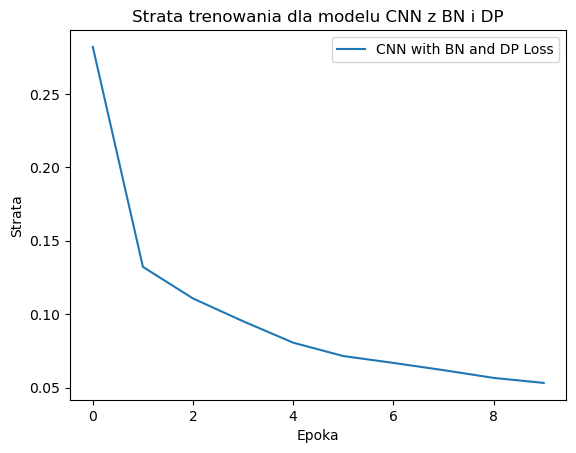

In [16]:
plt.plot(CNN_BN_DP_losses, label='CNN with BN and DP Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Strata trenowania dla modelu CNN z BN i DP')
plt.legend()
plt.show()

## Szybkie porównanie wszystkich 3 

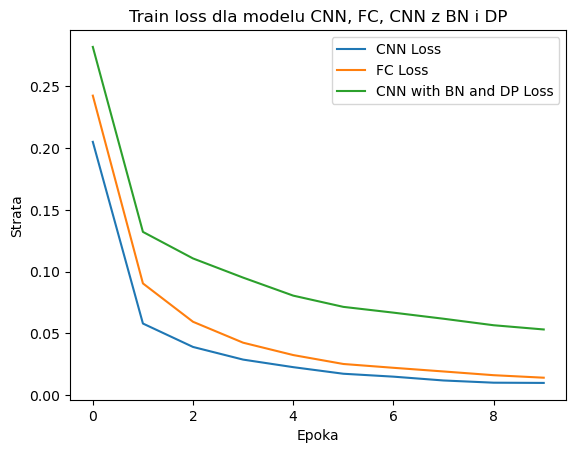

In [18]:
plt.plot(CNN_losses, label='CNN Loss')
plt.plot(fc_losses, label='FC Loss')
plt.plot(CNN_BN_DP_losses, label='CNN with BN and DP Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Train loss dla modelu CNN, FC, CNN z BN i DP')
plt.legend()
plt.show()

| Model                | Accuracy    |
|----------------------| ----------- |
| Fully Connected (FC) |    97.91    |
| CNN                  |    99.28    |
| CNN + BN + Dropout   |    99.30    |

- Model FC osiąga bardzo dobrą dokładność (~98%), jednak nie wykorzystuje informacji przestrzennej obrazu, co ogranicza jego możliwości w bardziej złożonych zadaniach.
- Model CNN dzięki warstwom konwolucyjnym i poolingowi lepiej wyłapuje cechy obrazu, co przekłada się na wyższą dokładność (~99.3%) i szybszą konwergencję.
- Dodanie Batch Normalizacji i Dropoutu w CNN nieznacznie poprawia wynik, ale przede wszystkim zwiększa odporność modelu na overfitting. W przypadku prostego zbioru MNIST różnice są minimalne, jednak dla trudniejszych danych regularizacja jest kluczowa.
- MNIST jest na tyle prostym zbiorem, że nawet proste modele osiągają bardzo wysoką skuteczność.
- Najważniejsze metryki to accuracy oraz przebieg funkcji straty – pozwalają ocenić zarówno skuteczność, jak i stabilność procesu uczenia. Przebieg funkcji straty ukazuje wyższy loss dla modelu CNN z BN i DP w porównaniu do standardowego CNN, co jest spowodowane uczeniem się modelu z normalizacją oraz dropoutem, który spowalnia process uczenia się modelu, ale zarazem zapewnia większą niezawodność.

## Nie można być gołosłownym we wnioskach, pokażemy teraz te różnicę na cifarze: data

In [5]:
from torchvision import datasets, transforms

cifar_train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())
cifar_test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())

print(f"Liczba przykładów w CIFAR-10 train: {len(cifar_train_dataset)}")
print(f"Liczba przykładów w CIFAR-10 test: {len(cifar_test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Liczba przykładów w CIFAR-10 train: 50000
Liczba przykładów w CIFAR-10 test: 10000


In [28]:
print(f'Shape obrazku: {cifar_test_dataset[0][0].shape}')

Shape obrazku: torch.Size([3, 32, 32])


czyli mamy 3 kanały (RGB) a kazdy obrazek jest 32x32

In [29]:
print(cifar_test_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


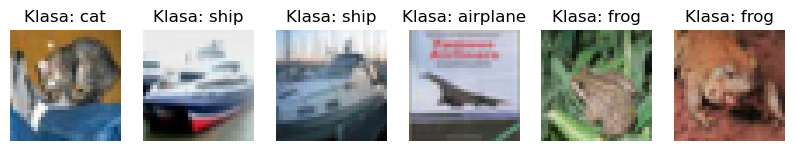

In [31]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i, (img, label) in enumerate([cifar_test_dataset[j] for j in range(6)]):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Klasa: {classes[label]}')
    axes[i].axis('off')
plt.show()

In [14]:
batchSize = 64

trainDataLoader = torch.utils.data.DataLoader(cifar_train_dataset, batch_size=batchSize, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=batchSize, shuffle=False)

## Niestety wcześniejsze architektury wymagają lekkiej zmiany, ponieważ mamy do czynienia teraz z 3 kanałami, a obrazki są 32x32, a nie 28x28.

In [69]:
class CIFAR_FC(nn.Module):
    def __init__(self):
        super(CIFAR_FC, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [70]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 4 * 4, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = self.classifier(x)
        return x

In [71]:
class CIFAR_CNN_BN_Dropout(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(CIFAR_CNN_BN_Dropout, self).__init__()
        
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, padding=1, stride=1, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_p),
            nn.MaxPool2d(kernel_size=2)
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, padding=1, stride=1, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_p),
            nn.MaxPool2d(kernel_size=2)
        )

        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, padding=1, stride=1, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_p),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 4 * 4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = self.classifier(x)
        return x

## Trenowanie modeli na cifarze

Przestuje tylko kilka roznych ustawien hiddenUnits i outputUnits, żeby nie zapocić komputerka

In [66]:
print("\nTrenowanie modelu CNN z droputem i BN:")
CIFAR_CNN_BN_Dropout_model = CIFAR_CNN_BN_Dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CIFAR_CNN_BN_Dropout_model.parameters(), lr=0.001)
CIFAR_CNN_BN_Dropout_losses = train_model(CIFAR_CNN_BN_Dropout_model, trainDataLoader, criterion, optimizer, epochs=20)
CIFAR_CNN_BN_Dropout_accuracy = test_model(CIFAR_CNN_BN_Dropout_model, testDataLoader)


Trenowanie modelu CNN z droputem i BN:
Epoka 1/20, Strata: 1.5984
Epoka 2/20, Strata: 1.3238
Epoka 3/20, Strata: 1.2172
Epoka 4/20, Strata: 1.1461
Epoka 5/20, Strata: 1.0917
Epoka 6/20, Strata: 1.0473
Epoka 7/20, Strata: 1.0137
Epoka 8/20, Strata: 0.9812
Epoka 9/20, Strata: 0.9530
Epoka 10/20, Strata: 0.9340
Epoka 11/20, Strata: 0.9170
Epoka 12/20, Strata: 0.8922
Epoka 13/20, Strata: 0.8801
Epoka 14/20, Strata: 0.8675
Epoka 15/20, Strata: 0.8484
Epoka 16/20, Strata: 0.8346
Epoka 17/20, Strata: 0.8180
Epoka 18/20, Strata: 0.8115
Epoka 19/20, Strata: 0.8067
Epoka 20/20, Strata: 0.7883
Dokładność na zestawie testowym: 75.53%


In [72]:
print("\nTrenowanie modelu CNN:")
CIFAR_CNN_model = CIFAR_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CIFAR_CNN_model.parameters(), lr=0.001)
CIFAR_CNN_losses = train_model(CIFAR_CNN_model, trainDataLoader, criterion, optimizer, epochs=20)
CIFAR_CNN_accuracy = test_model(CIFAR_CNN_model, testDataLoader)


Trenowanie modelu CNN:
Epoka 1/20, Strata: 1.5683
Epoka 2/20, Strata: 1.1673
Epoka 3/20, Strata: 0.9989
Epoka 4/20, Strata: 0.8763
Epoka 5/20, Strata: 0.7799
Epoka 6/20, Strata: 0.6925
Epoka 7/20, Strata: 0.6196
Epoka 8/20, Strata: 0.5498
Epoka 9/20, Strata: 0.4836
Epoka 10/20, Strata: 0.4220
Epoka 11/20, Strata: 0.3602
Epoka 12/20, Strata: 0.3073
Epoka 13/20, Strata: 0.2601
Epoka 14/20, Strata: 0.2158
Epoka 15/20, Strata: 0.1784
Epoka 16/20, Strata: 0.1578
Epoka 17/20, Strata: 0.1289
Epoka 18/20, Strata: 0.1217
Epoka 19/20, Strata: 0.1150
Epoka 20/20, Strata: 0.0989
Dokładność na zestawie testowym: 71.41%


In [73]:
print("\nTrenowanie modelu FC:")
CIFAR_FC_model = CIFAR_FC().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CIFAR_FC_model.parameters(), lr=0.001)
CIFAR_FC_losses = train_model(CIFAR_FC_model, trainDataLoader, criterion, optimizer, epochs=20)
CIFAR_FC_accuracy = test_model(CIFAR_FC_model, testDataLoader)


Trenowanie modelu FC:
Epoka 1/20, Strata: 1.8292
Epoka 2/20, Strata: 1.6515
Epoka 3/20, Strata: 1.5656
Epoka 4/20, Strata: 1.5119
Epoka 5/20, Strata: 1.4715
Epoka 6/20, Strata: 1.4337
Epoka 7/20, Strata: 1.4128
Epoka 8/20, Strata: 1.3807
Epoka 9/20, Strata: 1.3589
Epoka 10/20, Strata: 1.3323
Epoka 11/20, Strata: 1.3122
Epoka 12/20, Strata: 1.2950
Epoka 13/20, Strata: 1.2720
Epoka 14/20, Strata: 1.2582
Epoka 15/20, Strata: 1.2422
Epoka 16/20, Strata: 1.2264
Epoka 17/20, Strata: 1.2119
Epoka 18/20, Strata: 1.1954
Epoka 19/20, Strata: 1.1786
Epoka 20/20, Strata: 1.1637
Dokładność na zestawie testowym: 49.73%


## Rezultat + wnioski

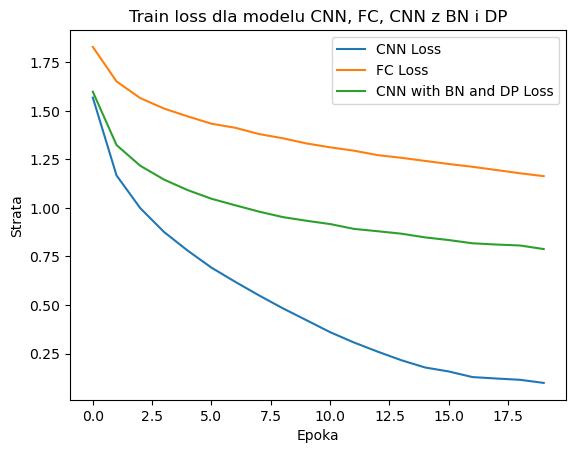

In [74]:
plt.plot(CIFAR_CNN_losses, label='CNN Loss')
plt.plot(CIFAR_FC_losses, label='FC Loss')
plt.plot(CIFAR_CNN_BN_Dropout_losses, label='CNN with BN and DP Loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Train loss dla modelu CNN, FC, CNN z BN i DP')
plt.legend()
plt.show()

| Model                | Accuracy    |
|----------------------| ----------- |
| Fully Connected (FC) |    49.73    |
| CNN                  |    71.41    |
| CNN + BN + Dropout   |    75.53    |

- Prosta sieć FC (Fully Connected) osiąga znacznie niższą dokładność (49.73%) niż modele konwolucyjne, co pokazuje, że dla bardziej złożonych danych (kolorowe obrazy, większa liczba klas) zachowanie informacji przestrzennej jest kluczowe.
- Podstawowy model CNN uzyskuje już dużo lepszy wynik (71.41%), dzięki wykorzystaniu warstw konwolucyjnych i poolingowych, które pozwalają na efektywne wyłapywanie cech obrazu.
- Dodanie Batch Normalizacji i Dropoutu do CNN poprawia zarówno dokładność (75.53%), jak i odporność na overfitting. Regularizacja jest szczególnie ważna dla bardziej złożonych zbiorów danych.
- Przebieg funkcji straty pokazuje, że modele regularizowane uczą się wolniej, ale są bardziej stabilne i mniej podatne na overfitting.

## Teraz testujemy dropout + głębokość, szerokość sieci, learning rate, SGD i adama, ilosc bloków konwolucyjnych i ilość neuronów, z powodu ilości obliczeń skupię się tylko na jednej architekturze 

In [8]:
class CIFAR_CNN_BN_Dropout(nn.Module):
    def __init__(self, num_blocks, out_channels_list, hidden_neurons, dropout_p):
        super(CIFAR_CNN_BN_Dropout, self).__init__()
        
        self.conv_blocks = nn.ModuleList()
        
        self.conv_blocks.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=out_channels_list[0], padding=1, stride=1, kernel_size=3),
            nn.BatchNorm2d(out_channels_list[0]),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_p),
            nn.MaxPool2d(kernel_size=2)
        ))
        
        for i in range(1, num_blocks):
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(in_channels=out_channels_list[i-1], out_channels=out_channels_list[i], padding=1, stride=1, kernel_size=3),
                nn.BatchNorm2d(out_channels_list[i]),
                nn.ReLU(),
                nn.Dropout2d(p=dropout_p),
                nn.MaxPool2d(kernel_size=2)
            ))
        
        spatial_size = 32 // (2 ** num_blocks)
        flat_features = out_channels_list[-1] * spatial_size * spatial_size
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flat_features, out_features=hidden_neurons),
            nn.BatchNorm1d(hidden_neurons),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=hidden_neurons, out_features=10)
        )
    
    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = self.classifier(x)
        return x

In [81]:
import itertools

dropout_ps = [0.2, 0.3, 0.4]
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam']
num_blocks_options = [2, 3]
out_channels_options = [32, 64, 128]
hidden_neurons_options = [256, 512, 1024]
epochs = 7

results = []

for dropout_p, lr, opt_name, num_blocks, hidden_neurons in itertools.product(
    dropout_ps, learning_rates, optimizers, num_blocks_options, hidden_neurons_options
):
    for out_channels in itertools.product(out_channels_options, repeat=num_blocks):
        out_channels_list = list(out_channels)
        print(f"Testowanie: dropout_p={dropout_p}, lr={lr} optimizer={opt_name}, "
              f"num_blocks={num_blocks}, out_channels={out_channels_list}, hidden_neurons={hidden_neurons}")

        model = CIFAR_CNN_BN_Dropout(num_blocks, out_channels_list, hidden_neurons, dropout_p).to(device)
            
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            
        losses, accuracy = train_model(model, trainDataLoader, criterion, optimizer, epochs), test_model(model, testDataLoader)
            
        results.append({
            'dropout_p': dropout_p,
            'learning_rate': lr,
            'optimizer': opt_name,
            'num_blocks': num_blocks,
            'out_channels': out_channels_list,
            'hidden_neurons': hidden_neurons,
            'accuracy': accuracy,
            'losses': losses
        })


Testowanie: dropout_p=0.2, lr=0.001 optimizer=SGD, num_blocks=2, out_channels=[32, 32], hidden_neurons=256
Epoka 1/7, Strata: 1.6570
Epoka 2/7, Strata: 1.3611
Epoka 3/7, Strata: 1.2466
Epoka 4/7, Strata: 1.1685
Epoka 5/7, Strata: 1.1149
Epoka 6/7, Strata: 1.0702
Epoka 7/7, Strata: 1.0338
Dokładność na zestawie testowym: 68.04%
Testowanie: dropout_p=0.2, lr=0.001 optimizer=SGD, num_blocks=2, out_channels=[32, 64], hidden_neurons=256
Epoka 1/7, Strata: 1.6111
Epoka 2/7, Strata: 1.3024
Epoka 3/7, Strata: 1.1761
Epoka 4/7, Strata: 1.0897
Epoka 5/7, Strata: 1.0330
Epoka 6/7, Strata: 0.9800
Epoka 7/7, Strata: 0.9453
Dokładność na zestawie testowym: 69.37%
Testowanie: dropout_p=0.2, lr=0.001 optimizer=SGD, num_blocks=2, out_channels=[32, 128], hidden_neurons=256
Epoka 1/7, Strata: 1.5472
Epoka 2/7, Strata: 1.2578
Epoka 3/7, Strata: 1.1393
Epoka 4/7, Strata: 1.0590
Epoka 5/7, Strata: 0.9939
Epoka 6/7, Strata: 0.9419
Epoka 7/7, Strata: 0.9015
Dokładność na zestawie testowym: 69.02%
Testowanie: 

KeyboardInterrupt: 

Wrociłem do domu, zrobiło sie sporo, ale nie taki był cel. Tak jak widać takie naiwne szukanie jest cholernie długie i obliczeniowo ciężkie, dlatego zaraz spróbujemy czegoś lepszego, ale najpierw zobaczmy wyniki

Najlepsze parametry:
dropout_p                                                       0.2
learning_rate                                                 0.001
optimizer                                                      Adam
num_blocks                                                        3
out_channels                                         [128, 64, 128]
hidden_neurons                                                  256
accuracy                                                      78.38
losses            [1.336903270248257, 1.0089401766619719, 0.8894...
Name: 158, dtype: object


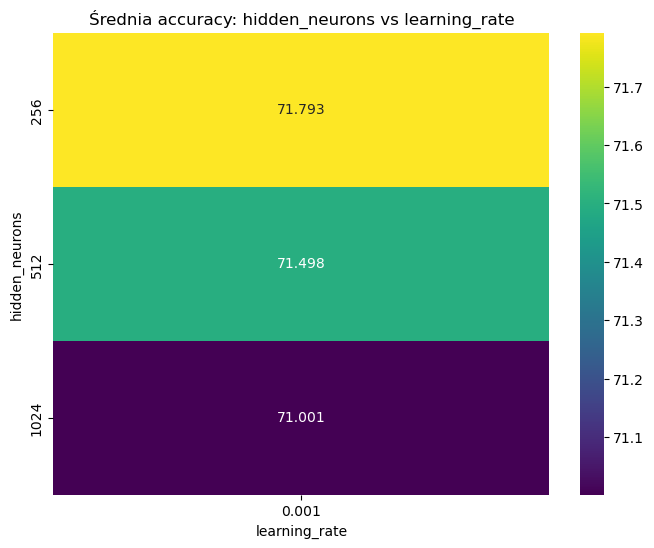

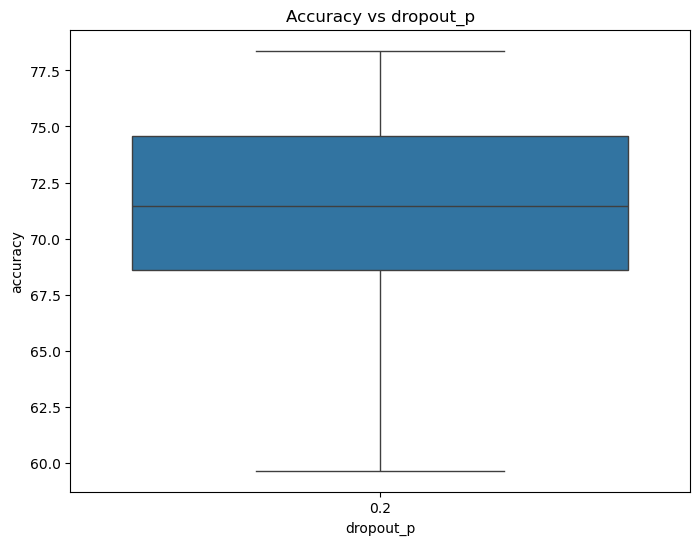

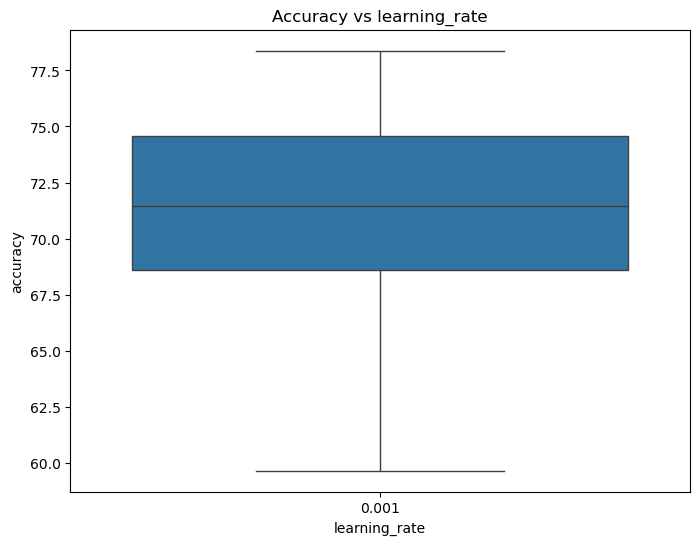

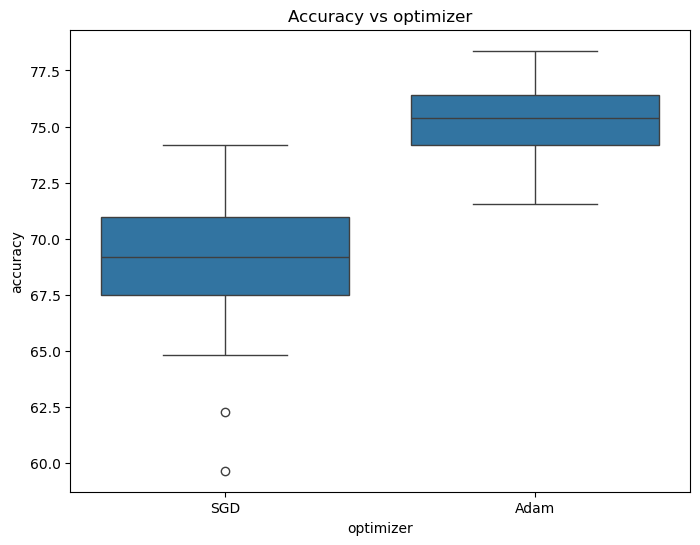

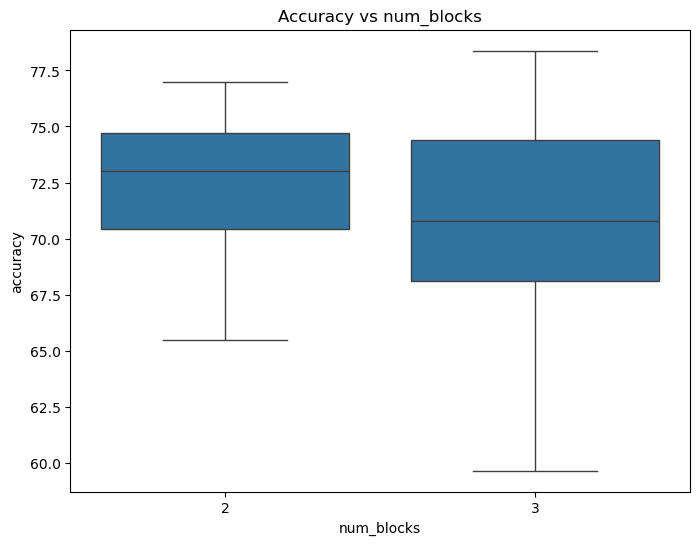

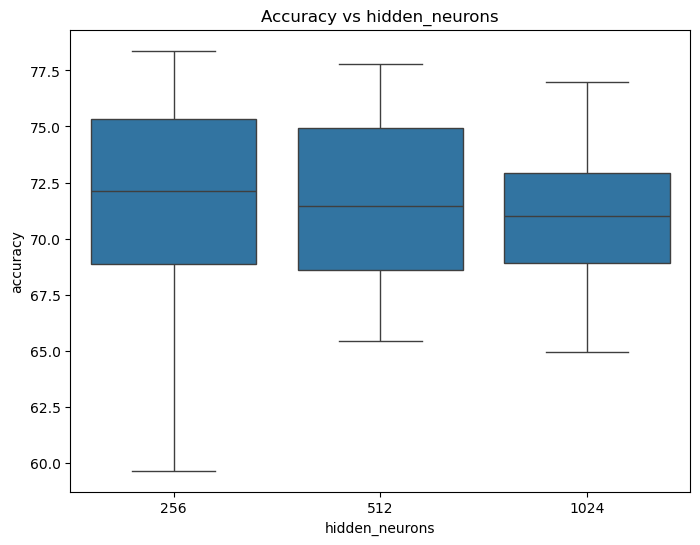

In [93]:
import pandas as pd
import seaborn as sns

res = pd.DataFrame(results)

best = res.loc[res["accuracy"].idxmax()]
print("Najlepsze parametry:")
print(best)

plt.figure(figsize=(8,6))
pivot = res.pivot_table(
    values="accuracy",
    index="hidden_neurons",
    columns="learning_rate",
    aggfunc="mean"
)
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Średnia accuracy: hidden_neurons vs learning_rate")
plt.show()

param_cols = [c for c in res.columns if c not in ["accuracy", "losses", "out_channels"]]

for col in param_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=res, x=col, y="accuracy")
    
    plt.title(f"Accuracy vs {col}")
    plt.show()



**Wnioski**:
- CHOLERNIE DŁUGO, totalnie bez sensu robić coś takiego na tak dużym datasecie i dosyć skomplikowanej architekturze
- Im większa, głębsza, bardziej skomplikowana sieć tym gorzej wypada na tak krótkim trainingu jak tylko 7 epok
- Adam poradził sobie znacząco lepiej niż basicowy SGD
- Nie ma co zostawiać kompa na prawie 4 h xd

Więc jak powinno sie to zrobić?

In [ ]:
import optuna

def objective(trial):
    dropout_p = trial.suggest_categorical("dropout_p", [0.2, 0.3, 0.4])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    num_blocks = trial.suggest_int("num_blocks", 2, 3)
    out_channels_list = [trial.suggest_categorical(f"out_ch_{i}", [32, 64, 128]) for i in range(num_blocks)]
    hidden_neurons = trial.suggest_categorical("hidden_neurons", [256, 512, 1024])

    model = CIFAR_CNN_BN_Dropout(num_blocks, out_channels_list, hidden_neurons, dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses, accuracy = train_model(model, trainDataLoader, criterion, optimizer, epochs=7), test_model(model, testDataLoader)

    return accuracy

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Najlepsze parametry:", study.best_params)
print("Najlepsza dokładność:", study.best_value)

[I 2025-08-21 20:22:52,227] A new study created in memory with name: no-name-d21ee70a-3242-4a79-a9a9-6fb0af044e92
C:\Users\litwi\AppData\Local\Temp\ipykernel_10600\2039582265.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)


Epoka 1/7, Strata: 1.7421
Epoka 2/7, Strata: 1.4751
Epoka 3/7, Strata: 1.3632
Epoka 4/7, Strata: 1.2901
Epoka 5/7, Strata: 1.2398
Epoka 6/7, Strata: 1.1967
Epoka 7/7, Strata: 1.1619


[I 2025-08-21 20:24:58,315] Trial 0 finished with value: 65.85 and parameters: {'dropout_p': 0.4, 'lr': 0.00010961603923015024, 'optimizer': 'SGD', 'num_blocks': 2, 'out_ch_0': 64, 'out_ch_1': 32, 'hidden_neurons': 1024}. Best is trial 0 with value: 65.85.


Dokładność na zestawie testowym: 65.85%
Epoka 1/7, Strata: 2.0095
Epoka 2/7, Strata: 1.8426
Epoka 3/7, Strata: 1.7865
Epoka 4/7, Strata: 1.7742
Epoka 5/7, Strata: 1.7244
Epoka 6/7, Strata: 1.6884
Epoka 7/7, Strata: 1.6587


[I 2025-08-21 20:26:21,258] Trial 1 finished with value: 46.88 and parameters: {'dropout_p': 0.4, 'lr': 0.08542064317380214, 'optimizer': 'SGD', 'num_blocks': 2, 'out_ch_0': 128, 'out_ch_1': 128, 'hidden_neurons': 256}. Best is trial 0 with value: 65.85.


Dokładność na zestawie testowym: 46.88%
Epoka 1/7, Strata: 1.6373
Epoka 2/7, Strata: 1.3227
Epoka 3/7, Strata: 1.1977
Epoka 4/7, Strata: 1.1301
Epoka 5/7, Strata: 1.0794
Epoka 6/7, Strata: 1.0444
Epoka 7/7, Strata: 1.0052


[I 2025-08-21 20:27:39,190] Trial 2 finished with value: 70.06 and parameters: {'dropout_p': 0.3, 'lr': 0.00013406712292541383, 'optimizer': 'SGD', 'num_blocks': 2, 'out_ch_0': 128, 'out_ch_1': 32, 'hidden_neurons': 256}. Best is trial 2 with value: 70.06.


Dokładność na zestawie testowym: 70.06%
Epoka 1/7, Strata: 1.5605
Epoka 2/7, Strata: 1.2490
Epoka 3/7, Strata: 1.1172
Epoka 4/7, Strata: 1.0427
Epoka 5/7, Strata: 0.9711
Epoka 6/7, Strata: 0.9267
Epoka 7/7, Strata: 0.8894


[I 2025-08-21 20:28:52,159] Trial 3 finished with value: 69.04 and parameters: {'dropout_p': 0.2, 'lr': 0.014407279306708903, 'optimizer': 'SGD', 'num_blocks': 2, 'out_ch_0': 32, 'out_ch_1': 32, 'hidden_neurons': 512}. Best is trial 2 with value: 70.06.


Dokładność na zestawie testowym: 69.04%
Epoka 1/7, Strata: 1.7128
Epoka 2/7, Strata: 1.3965
Epoka 3/7, Strata: 1.2748
Epoka 4/7, Strata: 1.1923
Epoka 5/7, Strata: 1.1479
Epoka 6/7, Strata: 1.1131
Epoka 7/7, Strata: 1.0719


[I 2025-08-21 20:30:15,444] Trial 4 finished with value: 67.59 and parameters: {'dropout_p': 0.2, 'lr': 0.024361308161566366, 'optimizer': 'SGD', 'num_blocks': 3, 'out_ch_0': 32, 'out_ch_1': 64, 'out_ch_2': 32, 'hidden_neurons': 512}. Best is trial 2 with value: 70.06.


Dokładność na zestawie testowym: 67.59%
Epoka 1/7, Strata: 1.9455
Epoka 2/7, Strata: 1.5465
Epoka 3/7, Strata: 1.4182
Epoka 4/7, Strata: 1.3400
Epoka 5/7, Strata: 1.2756
Epoka 6/7, Strata: 1.2357
Epoka 7/7, Strata: 1.2011


[I 2025-08-21 20:31:44,293] Trial 5 finished with value: 64.93 and parameters: {'dropout_p': 0.3, 'lr': 0.02738490955325363, 'optimizer': 'Adam', 'num_blocks': 3, 'out_ch_0': 64, 'out_ch_1': 128, 'out_ch_2': 32, 'hidden_neurons': 1024}. Best is trial 2 with value: 70.06.


Dokładność na zestawie testowym: 64.93%
Epoka 1/7, Strata: 1.6840
Epoka 2/7, Strata: 1.3792
Epoka 3/7, Strata: 1.2498
Epoka 4/7, Strata: 1.1588
Epoka 5/7, Strata: 1.0924
Epoka 6/7, Strata: 1.0416
Epoka 7/7, Strata: 0.9960


[I 2025-08-21 20:33:05,430] Trial 6 finished with value: 69.22 and parameters: {'dropout_p': 0.4, 'lr': 0.007116322245267564, 'optimizer': 'Adam', 'num_blocks': 2, 'out_ch_0': 32, 'out_ch_1': 128, 'hidden_neurons': 512}. Best is trial 2 with value: 70.06.


Dokładność na zestawie testowym: 69.22%
Epoka 1/7, Strata: 1.5227
Epoka 2/7, Strata: 1.1911
Epoka 3/7, Strata: 1.0607
Epoka 4/7, Strata: 0.9839
Epoka 5/7, Strata: 0.9249
Epoka 6/7, Strata: 0.8703
Epoka 7/7, Strata: 0.8341


[I 2025-08-21 20:34:31,054] Trial 7 finished with value: 75.09 and parameters: {'dropout_p': 0.2, 'lr': 0.0003167254918763353, 'optimizer': 'Adam', 'num_blocks': 3, 'out_ch_0': 64, 'out_ch_1': 64, 'out_ch_2': 64, 'hidden_neurons': 256}. Best is trial 7 with value: 75.09.


Dokładność na zestawie testowym: 75.09%
Epoka 1/7, Strata: 1.4551
Epoka 2/7, Strata: 1.1133
Epoka 3/7, Strata: 0.9742
Epoka 4/7, Strata: 0.8811
Epoka 5/7, Strata: 0.8184
Epoka 6/7, Strata: 0.7594
Epoka 7/7, Strata: 0.7130


[I 2025-08-21 20:36:00,209] Trial 8 finished with value: 77.25 and parameters: {'dropout_p': 0.3, 'lr': 0.002157247646469007, 'optimizer': 'Adam', 'num_blocks': 3, 'out_ch_0': 128, 'out_ch_1': 128, 'out_ch_2': 128, 'hidden_neurons': 512}. Best is trial 8 with value: 77.25.


Dokładność na zestawie testowym: 77.25%
Epoka 1/7, Strata: 1.4137
Epoka 2/7, Strata: 1.0736
Epoka 3/7, Strata: 0.9350
Epoka 4/7, Strata: 0.8299
Epoka 5/7, Strata: 0.7621
Epoka 6/7, Strata: 0.6909
Epoka 7/7, Strata: 0.6320


[I 2025-08-21 20:37:19,979] Trial 9 finished with value: 72.85 and parameters: {'dropout_p': 0.2, 'lr': 0.004191514061871911, 'optimizer': 'Adam', 'num_blocks': 2, 'out_ch_0': 128, 'out_ch_1': 32, 'hidden_neurons': 512}. Best is trial 8 with value: 77.25.


Dokładność na zestawie testowym: 72.85%
Najlepsze parametry: {'dropout_p': 0.3, 'lr': 0.002157247646469007, 'optimizer': 'Adam', 'num_blocks': 3, 'out_ch_0': 128, 'out_ch_1': 128, 'out_ch_2': 128, 'hidden_neurons': 512}
Najlepsza dokładność: 77.25


Jak widać dokładność jest nieco mniejsza, ale warto tutaj się na chwile zatrzymać i pomyśleć jak działa wyszukiwanie hiperparametrów

W zadaniu drugim widać było rozwiązania korzystające ze sprawdzania wszelkich możliwych parametrów do potęgi 7, gridsearchem czy manualnie. To jest super opcja dla prostych do wytrenowania modeli ml na małych datasetach. Ale przy takim cifarze i dobrej architekturze robią się schody. Musimy mieć na myśli czas i rezultat/dokładność. 

W **4 h** znalazłem roziwązanie dające **78.38%** korzystając "z wszystko ze wszstkim", daje nam to najlepszy rezultat, ale jest okupione ogromnym kosztem czas + moc obliczeniowa, natomiast korzystajac z optuny i randomowego searchowania **77.25%** ale w niecałe **15 minut**, uważam że to dobra cena/jakość.

Optuna i wiele innych narzędzi korzysta z algorytmów, które na bieżąco wyszukują najbardziej obiecujące hiperparametry i skupia sie na nich w nastepnym etapie, równiez korzystajac z randomized searcha, ktory choc moze pominac najlepsze rezultaty jak w naszym przypadku, to ma tendecje bedac sparowanym z tymi algorytmami do zwracania sensownych ustawien modelu w sensownym czasie